## Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
!pip install torchsummary
from torchsummary import summary

In [ ]:
# install Albumentations
!pip install git+https://github.com/albumentations-team/albumentations.git
!pip install albumentations

  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-3tvak_jr
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-3tvak_jr
  Resolved https://github.com/albumentations-team/albumentations.git to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.1-py3-none-any.whl size=125700 sha256=e4286eff568e30b710d7b0233a9fb519a5f76b7bb51b1b01eac974e3480bbb90
  Stored in directory: /tmp/pip-ephem-wheel-cache-mwanweil/wheels/f9/34/b6/eb7adf92e69b5629d7de6904c0d4ac4e5050b18ce065bab4e1
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [ ]:
# mounting google drive folder
from google.colab import drive
drive.mount('/content/drive')
BASE_DIR='/content/drive/My Drive/session10'
%cd $BASE_DIR

Mounted at /content/drive
/content/drive/My Drive/session10


In [ ]:
from albumentations.pytorch import ToTensorV2
from data_transformations.data_transform_cifar10_custom_resnet import get_train_transform, get_test_transform
from data_loaders.cifar10_data_loader import get_train_loader, get_test_loader, get_classes
from model.customresnet import CustomResNet, train_test_loader, imshow, get_model, find_lr_value, train_model
from utils.train_test_function import train,test
from utils.accuracy_plot import get_test_accuracy,get_accuracy_per_class
from utils.plot_metrics import plot_loss_accuracy,plot_accuracy,plot_max_lr_vs_test_accuracy
from utils.misclassified_images import  display_misclassfied_ciphar10_images
from utils.gradcam import GRADCAM, PLOT,PLOTGRADCAM,process_for_grad_cam
from utils.cyclic_lr import triangle_lr_plot,custom_one_cycle_lr, max_lr_finder_schedule

In [ ]:
BATCH_SIZE=512
trainloader, testloader, classes,transform_train,transform_test = train_test_loader(BATCH_SIZE,get_train_transform, get_test_transform,get_train_loader, get_test_loader, get_classes)

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


100%|██████████| 170498071/170498071 [00:01<00:00, 95055255.15it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


 deer  bird truck   dog   dog  deer  ship  deer  deer   cat  deer  frog   car plane truck plane  ship plane  ship   car  frog  ship   cat   dog   dog  frog  ship  bird  ship truck   cat   dog horse horse  ship  deer plane plane  ship truck horse  frog  bird   cat truck  ship   cat  bird horse  bird   car   car  deer  bird  bird truck  frog horse   car plane  deer horse  bird  ship  deer  ship  frog  ship  deer   cat   dog   cat  bird plane truck   car horse   cat plane   car  frog  frog plane truck horse  deer truck plane  bird plane plane   car  deer plane  bird  frog horse  deer  bird  deer plane  deer  ship  frog  deer   cat  deer  ship  ship   car   dog  deer  ship   dog   cat   cat  ship truck  ship horse  ship   car  ship   car  ship   car   cat  ship


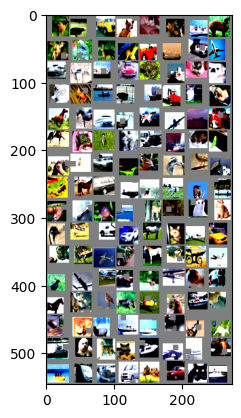

In [ ]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
# show images
imshow(torchvision.utils.make_grid(images[0:128]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(128)))

## Define custom ResNet Model

In [ ]:
model = get_model(CustomResNet)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         Dropout2d-3           [-1, 64, 32, 32]               0
       ConvBNBlock-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
         Dropout2d-8          [-1, 128, 16, 16]               0
   TransitionBlock-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
        Dropout2d-12          [-1, 128, 16, 16]               0
      ConvBNBlock-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 128,

/content/drive/My Drive/session10/model/customresnet.py:83: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


## LR Range Test

In [ ]:
model = get_model(CustomResNet)
PATH_BASE_MODEL = 'base_weights_lr_range_test.pth'
torch.save(model.state_dict(), PATH_BASE_MODEL)
EPOCHS_TO_TRY = 5
max_lr_list = [0.001, 0.004, 0.008, 0.01,0.04,0.08,0.1,0.4,0.8,1,2,4]
test_accuracy_list = []
find_lr_value(model,EPOCHS_TO_TRY,max_lr_list,test_accuracy_list,PATH_BASE_MODEL,max_lr_finder_schedule,BATCH_SIZE,train,test,trainloader,testloader)

MAX LR: 0.001  EPOCH: 1


Loss=2.884324073791504 Batch_id=97 Accuracy=8.91: 100%|██████████| 98/98 [00:23<00:00,  4.14it/s]



Test set: Average loss: 2.9626, Accuracy: 857/10000 (8.57%)

MAX LR: 0.001  EPOCH: 2


Loss=2.94871187210083 Batch_id=97 Accuracy=9.05: 100%|██████████| 98/98 [00:21<00:00,  4.62it/s]



Test set: Average loss: 2.9548, Accuracy: 869/10000 (8.69%)

MAX LR: 0.001  EPOCH: 3


Loss=3.0513243675231934 Batch_id=97 Accuracy=8.81: 100%|██████████| 98/98 [00:23<00:00,  4.19it/s]



Test set: Average loss: 2.9350, Accuracy: 871/10000 (8.71%)

MAX LR: 0.001  EPOCH: 4


Loss=2.846564531326294 Batch_id=97 Accuracy=8.88: 100%|██████████| 98/98 [00:21<00:00,  4.54it/s]



Test set: Average loss: 2.9032, Accuracy: 867/10000 (8.67%)

MAX LR: 0.001  EPOCH: 5


Loss=2.8124542236328125 Batch_id=97 Accuracy=8.93: 100%|██████████| 98/98 [00:21<00:00,  4.50it/s]



Test set: Average loss: 2.8820, Accuracy: 887/10000 (8.87%)

 For Max LR:  0.001  Test Accuracy:  8.87
MAX LR: 0.004  EPOCH: 1


Loss=2.7818984985351562 Batch_id=97 Accuracy=8.85: 100%|██████████| 98/98 [00:23<00:00,  4.25it/s]



Test set: Average loss: 2.8713, Accuracy: 883/10000 (8.83%)

MAX LR: 0.004  EPOCH: 2


Loss=2.653188705444336 Batch_id=97 Accuracy=9.32: 100%|██████████| 98/98 [00:21<00:00,  4.51it/s]



Test set: Average loss: 2.7207, Accuracy: 897/10000 (8.97%)

MAX LR: 0.004  EPOCH: 3


Loss=2.522280216217041 Batch_id=97 Accuracy=9.66: 100%|██████████| 98/98 [00:23<00:00,  4.26it/s]



Test set: Average loss: 2.5703, Accuracy: 970/10000 (9.70%)

MAX LR: 0.004  EPOCH: 4


Loss=2.4446396827697754 Batch_id=97 Accuracy=10.61: 100%|██████████| 98/98 [00:22<00:00,  4.40it/s]



Test set: Average loss: 2.4439, Accuracy: 1101/10000 (11.01%)

MAX LR: 0.004  EPOCH: 5


Loss=2.318114995956421 Batch_id=97 Accuracy=11.86: 100%|██████████| 98/98 [00:22<00:00,  4.40it/s]



Test set: Average loss: 2.3685, Accuracy: 1254/10000 (12.54%)

 For Max LR:  0.004  Test Accuracy:  12.54
MAX LR: 0.008  EPOCH: 1


Loss=2.601461410522461 Batch_id=97 Accuracy=9.11: 100%|██████████| 98/98 [00:23<00:00,  4.17it/s]



Test set: Average loss: 2.6613, Accuracy: 926/10000 (9.26%)

MAX LR: 0.008  EPOCH: 2


Loss=2.3497700691223145 Batch_id=97 Accuracy=10.91: 100%|██████████| 98/98 [00:22<00:00,  4.43it/s]



Test set: Average loss: 2.4033, Accuracy: 1183/10000 (11.83%)

MAX LR: 0.008  EPOCH: 3


Loss=2.3345305919647217 Batch_id=97 Accuracy=13.19: 100%|██████████| 98/98 [00:22<00:00,  4.39it/s]



Test set: Average loss: 2.3012, Accuracy: 1474/10000 (14.74%)

MAX LR: 0.008  EPOCH: 4


Loss=2.250764846801758 Batch_id=97 Accuracy=15.58: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]



Test set: Average loss: 2.2441, Accuracy: 1740/10000 (17.40%)

MAX LR: 0.008  EPOCH: 5


Loss=2.2441728115081787 Batch_id=97 Accuracy=17.92: 100%|██████████| 98/98 [00:22<00:00,  4.44it/s]



Test set: Average loss: 2.1899, Accuracy: 1971/10000 (19.71%)

 For Max LR:  0.008  Test Accuracy:  19.71
MAX LR: 0.01  EPOCH: 1


Loss=2.4757418632507324 Batch_id=97 Accuracy=9.33: 100%|██████████| 98/98 [00:22<00:00,  4.41it/s]



Test set: Average loss: 2.5529, Accuracy: 965/10000 (9.65%)

MAX LR: 0.01  EPOCH: 2


Loss=2.3447470664978027 Batch_id=97 Accuracy=11.55: 100%|██████████| 98/98 [00:23<00:00,  4.17it/s]



Test set: Average loss: 2.3292, Accuracy: 1349/10000 (13.49%)

MAX LR: 0.01  EPOCH: 3


Loss=2.230595827102661 Batch_id=97 Accuracy=14.77: 100%|██████████| 98/98 [00:22<00:00,  4.45it/s]



Test set: Average loss: 2.2518, Accuracy: 1707/10000 (17.07%)

MAX LR: 0.01  EPOCH: 4


Loss=2.20111346244812 Batch_id=97 Accuracy=17.85: 100%|██████████| 98/98 [00:22<00:00,  4.41it/s]



Test set: Average loss: 2.1842, Accuracy: 1989/10000 (19.89%)

MAX LR: 0.01  EPOCH: 5


Loss=2.156376361846924 Batch_id=97 Accuracy=20.38: 100%|██████████| 98/98 [00:23<00:00,  4.17it/s]



Test set: Average loss: 2.1176, Accuracy: 2264/10000 (22.64%)

 For Max LR:  0.01  Test Accuracy:  22.64
MAX LR: 0.04  EPOCH: 1


Loss=2.1210813522338867 Batch_id=97 Accuracy=15.60: 100%|██████████| 98/98 [00:22<00:00,  4.38it/s]



Test set: Average loss: 2.1080, Accuracy: 2349/10000 (23.49%)

MAX LR: 0.04  EPOCH: 2


Loss=1.9659799337387085 Batch_id=97 Accuracy=25.57: 100%|██████████| 98/98 [00:22<00:00,  4.35it/s]



Test set: Average loss: 1.8875, Accuracy: 3192/10000 (31.92%)

MAX LR: 0.04  EPOCH: 3


Loss=1.8491336107254028 Batch_id=97 Accuracy=31.57: 100%|██████████| 98/98 [00:23<00:00,  4.18it/s]



Test set: Average loss: 1.7258, Accuracy: 3766/10000 (37.66%)

MAX LR: 0.04  EPOCH: 4


Loss=1.6879768371582031 Batch_id=97 Accuracy=36.31: 100%|██████████| 98/98 [00:21<00:00,  4.46it/s]



Test set: Average loss: 1.6047, Accuracy: 4227/10000 (42.27%)

MAX LR: 0.04  EPOCH: 5


Loss=1.5347330570220947 Batch_id=97 Accuracy=40.25: 100%|██████████| 98/98 [00:22<00:00,  4.31it/s]



Test set: Average loss: 1.5090, Accuracy: 4585/10000 (45.85%)

 For Max LR:  0.04  Test Accuracy:  45.85
MAX LR: 0.08  EPOCH: 1


Loss=1.8804075717926025 Batch_id=97 Accuracy=22.01: 100%|██████████| 98/98 [00:23<00:00,  4.24it/s]



Test set: Average loss: 1.8309, Accuracy: 3404/10000 (34.04%)

MAX LR: 0.08  EPOCH: 2


Loss=1.6288076639175415 Batch_id=97 Accuracy=35.44: 100%|██████████| 98/98 [00:22<00:00,  4.42it/s]



Test set: Average loss: 1.5699, Accuracy: 4344/10000 (43.44%)

MAX LR: 0.08  EPOCH: 3


Loss=1.5826973915100098 Batch_id=97 Accuracy=42.51: 100%|██████████| 98/98 [00:23<00:00,  4.21it/s]



Test set: Average loss: 1.4300, Accuracy: 4802/10000 (48.02%)

MAX LR: 0.08  EPOCH: 4


Loss=1.4109725952148438 Batch_id=97 Accuracy=48.17: 100%|██████████| 98/98 [00:22<00:00,  4.27it/s]



Test set: Average loss: 1.3056, Accuracy: 5308/10000 (53.08%)

MAX LR: 0.08  EPOCH: 5


Loss=1.2727651596069336 Batch_id=97 Accuracy=52.66: 100%|██████████| 98/98 [00:22<00:00,  4.42it/s]



Test set: Average loss: 1.2040, Accuracy: 5705/10000 (57.05%)

 For Max LR:  0.08  Test Accuracy:  57.05
MAX LR: 0.1  EPOCH: 1


Loss=1.8479835987091064 Batch_id=97 Accuracy=24.51: 100%|██████████| 98/98 [00:23<00:00,  4.22it/s]



Test set: Average loss: 1.7318, Accuracy: 3740/10000 (37.40%)

MAX LR: 0.1  EPOCH: 2


Loss=1.5724469423294067 Batch_id=97 Accuracy=38.71: 100%|██████████| 98/98 [00:22<00:00,  4.31it/s]



Test set: Average loss: 1.4876, Accuracy: 4614/10000 (46.14%)

MAX LR: 0.1  EPOCH: 3


Loss=1.3933360576629639 Batch_id=97 Accuracy=46.30: 100%|██████████| 98/98 [00:22<00:00,  4.43it/s]



Test set: Average loss: 1.3482, Accuracy: 5087/10000 (50.87%)

MAX LR: 0.1  EPOCH: 4


Loss=1.2476259469985962 Batch_id=97 Accuracy=52.48: 100%|██████████| 98/98 [00:23<00:00,  4.18it/s]



Test set: Average loss: 1.2235, Accuracy: 5582/10000 (55.82%)

MAX LR: 0.1  EPOCH: 5


Loss=1.1857538223266602 Batch_id=97 Accuracy=56.92: 100%|██████████| 98/98 [00:22<00:00,  4.39it/s]



Test set: Average loss: 1.1808, Accuracy: 5835/10000 (58.35%)

 For Max LR:  0.1  Test Accuracy:  58.35
MAX LR: 0.4  EPOCH: 1


Loss=1.5120569467544556 Batch_id=97 Accuracy=39.48: 100%|██████████| 98/98 [00:22<00:00,  4.40it/s]



Test set: Average loss: 1.5686, Accuracy: 4559/10000 (45.59%)

MAX LR: 0.4  EPOCH: 2


Loss=1.0608915090560913 Batch_id=97 Accuracy=56.39: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]



Test set: Average loss: 1.3196, Accuracy: 5768/10000 (57.68%)

MAX LR: 0.4  EPOCH: 3


Loss=0.8938130736351013 Batch_id=97 Accuracy=63.93: 100%|██████████| 98/98 [00:22<00:00,  4.38it/s]



Test set: Average loss: 1.1197, Accuracy: 6333/10000 (63.33%)

MAX LR: 0.4  EPOCH: 4


Loss=0.8138875365257263 Batch_id=97 Accuracy=68.98: 100%|██████████| 98/98 [00:22<00:00,  4.44it/s]



Test set: Average loss: 1.2317, Accuracy: 6538/10000 (65.38%)

MAX LR: 0.4  EPOCH: 5


Loss=0.620562732219696 Batch_id=97 Accuracy=73.09: 100%|██████████| 98/98 [00:23<00:00,  4.18it/s]



Test set: Average loss: 0.7599, Accuracy: 7536/10000 (75.36%)

 For Max LR:  0.4  Test Accuracy:  75.36
MAX LR: 0.8  EPOCH: 1


Loss=1.5018914937973022 Batch_id=97 Accuracy=30.17: 100%|██████████| 98/98 [00:22<00:00,  4.40it/s]



Test set: Average loss: 1.5749, Accuracy: 4554/10000 (45.54%)

MAX LR: 0.8  EPOCH: 2


Loss=1.248979091644287 Batch_id=97 Accuracy=50.11: 100%|██████████| 98/98 [00:22<00:00,  4.37it/s]



Test set: Average loss: 1.5717, Accuracy: 4919/10000 (49.19%)

MAX LR: 0.8  EPOCH: 3


Loss=1.2127792835235596 Batch_id=97 Accuracy=58.85: 100%|██████████| 98/98 [00:23<00:00,  4.15it/s]



Test set: Average loss: 1.7402, Accuracy: 5302/10000 (53.02%)

MAX LR: 0.8  EPOCH: 4


Loss=1.3462082147598267 Batch_id=97 Accuracy=64.23: 100%|██████████| 98/98 [00:22<00:00,  4.45it/s]



Test set: Average loss: 1.8699, Accuracy: 6016/10000 (60.16%)

MAX LR: 0.8  EPOCH: 5


Loss=0.9040482640266418 Batch_id=97 Accuracy=67.96: 100%|██████████| 98/98 [00:22<00:00,  4.26it/s]



Test set: Average loss: 1.0645, Accuracy: 6822/10000 (68.22%)

 For Max LR:  0.8  Test Accuracy:  68.22
MAX LR: 1  EPOCH: 1


Loss=1.8729248046875 Batch_id=97 Accuracy=27.19: 100%|██████████| 98/98 [00:23<00:00,  4.18it/s]



Test set: Average loss: 2.6477, Accuracy: 3026/10000 (30.26%)

MAX LR: 1  EPOCH: 2


Loss=1.245424509048462 Batch_id=97 Accuracy=44.43: 100%|██████████| 98/98 [00:22<00:00,  4.32it/s]



Test set: Average loss: 1.5054, Accuracy: 4822/10000 (48.22%)

MAX LR: 1  EPOCH: 3


Loss=1.2984623908996582 Batch_id=97 Accuracy=54.29: 100%|██████████| 98/98 [00:22<00:00,  4.28it/s]



Test set: Average loss: 1.5138, Accuracy: 5354/10000 (53.54%)

MAX LR: 1  EPOCH: 4


Loss=1.3605611324310303 Batch_id=97 Accuracy=61.36: 100%|██████████| 98/98 [00:23<00:00,  4.15it/s]



Test set: Average loss: 1.8612, Accuracy: 4771/10000 (47.71%)

MAX LR: 1  EPOCH: 5


Loss=0.8210506439208984 Batch_id=97 Accuracy=67.46: 100%|██████████| 98/98 [00:21<00:00,  4.46it/s]



Test set: Average loss: 1.3730, Accuracy: 6612/10000 (66.12%)

 For Max LR:  1  Test Accuracy:  66.12
MAX LR: 2  EPOCH: 1


Loss=3.632746458053589 Batch_id=97 Accuracy=12.14: 100%|██████████| 98/98 [00:22<00:00,  4.29it/s]



Test set: Average loss: 2.4998, Accuracy: 1640/10000 (16.40%)

MAX LR: 2  EPOCH: 2


Loss=2.009006977081299 Batch_id=97 Accuracy=19.28: 100%|██████████| 98/98 [00:23<00:00,  4.23it/s]



Test set: Average loss: 1.9099, Accuracy: 2700/10000 (27.00%)

MAX LR: 2  EPOCH: 3


Loss=1.6782902479171753 Batch_id=97 Accuracy=30.73: 100%|██████████| 98/98 [00:21<00:00,  4.46it/s]



Test set: Average loss: 1.7120, Accuracy: 3567/10000 (35.67%)

MAX LR: 2  EPOCH: 4


Loss=1.526011347770691 Batch_id=97 Accuracy=40.73: 100%|██████████| 98/98 [00:22<00:00,  4.30it/s]



Test set: Average loss: 1.7433, Accuracy: 3867/10000 (38.67%)

MAX LR: 2  EPOCH: 5


Loss=1.3200693130493164 Batch_id=97 Accuracy=48.96: 100%|██████████| 98/98 [00:22<00:00,  4.28it/s]



Test set: Average loss: 1.5371, Accuracy: 4638/10000 (46.38%)

 For Max LR:  2  Test Accuracy:  46.38
MAX LR: 4  EPOCH: 1


Loss=2.178291082382202 Batch_id=97 Accuracy=12.80: 100%|██████████| 98/98 [00:22<00:00,  4.45it/s]



Test set: Average loss: 2.1850, Accuracy: 1629/10000 (16.29%)

MAX LR: 4  EPOCH: 2


Loss=2.1903975009918213 Batch_id=97 Accuracy=17.11: 100%|██████████| 98/98 [00:21<00:00,  4.49it/s]



Test set: Average loss: 2.1605, Accuracy: 1666/10000 (16.66%)

MAX LR: 4  EPOCH: 3


Loss=2.067239761352539 Batch_id=97 Accuracy=18.66: 100%|██████████| 98/98 [00:22<00:00,  4.29it/s]



Test set: Average loss: 2.0671, Accuracy: 1880/10000 (18.80%)

MAX LR: 4  EPOCH: 4


Loss=2.120089054107666 Batch_id=97 Accuracy=18.38: 100%|██████████| 98/98 [00:22<00:00,  4.37it/s]



Test set: Average loss: 2.2316, Accuracy: 1581/10000 (15.81%)

MAX LR: 4  EPOCH: 5


Loss=2.037611484527588 Batch_id=97 Accuracy=17.88: 100%|██████████| 98/98 [00:21<00:00,  4.47it/s]



Test set: Average loss: 2.0229, Accuracy: 1861/10000 (18.61%)

 For Max LR:  4  Test Accuracy:  18.61


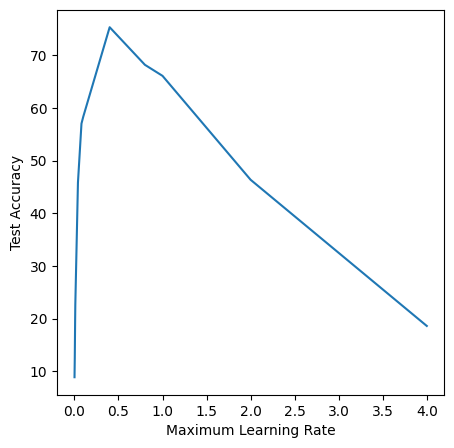

In [ ]:
plot_max_lr_vs_test_accuracy(max_lr_list,test_accuracy_list)

## Model Training

In [ ]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [ ]:
model = get_model(CustomResNet)
optimizer = optim.SGD(model.parameters(), lr=0.04, momentum=0.9)
EPOCHS = 24

one_cyle_lr = custom_one_cycle_lr(no_of_images=50176, batch_size=BATCH_SIZE, base_lr=0.08, max_lr=0.8, final_lr=0.008, epoch_stage1=5, epoch_stage2=18, total_epochs=24)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[one_cyle_lr])
PATH = '/content/drive/My Drive/cifar10_resnet18_one_cyclic_lr_final.pth'
torch.save(model.state_dict(), PATH)
best_test_accuracy = 0.0
train_model(best_test_accuracy,EPOCHS, model,trainloader,testloader,optimizer,train,test,train_losses,test_losses,scheduler,train_acc,test_acc,PATH)

EPOCH: 1


Loss=1.5430887937545776 Batch_id=97 Accuracy=40.42: 100%|██████████| 98/98 [00:23<00:00,  4.21it/s]



Test set: Average loss: 1.4836, Accuracy: 4872/10000 (48.72%)

Test Accuracy: 48.72 has increased. Saving the model
EPOCH: 2


Loss=1.1940348148345947 Batch_id=97 Accuracy=57.93: 100%|██████████| 98/98 [00:21<00:00,  4.46it/s]



Test set: Average loss: 2.1974, Accuracy: 5086/10000 (50.86%)

Test Accuracy: 50.86 has increased. Saving the model
EPOCH: 3


Loss=0.7818192839622498 Batch_id=97 Accuracy=66.78: 100%|██████████| 98/98 [00:21<00:00,  4.48it/s]



Test set: Average loss: 1.2094, Accuracy: 6317/10000 (63.17%)

Test Accuracy: 63.17 has increased. Saving the model
EPOCH: 4


Loss=0.9456764459609985 Batch_id=97 Accuracy=69.72: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]



Test set: Average loss: 0.9750, Accuracy: 7246/10000 (72.46%)

Test Accuracy: 72.46 has increased. Saving the model
EPOCH: 5


Loss=1.0293563604354858 Batch_id=97 Accuracy=73.38: 100%|██████████| 98/98 [00:22<00:00,  4.39it/s]



Test set: Average loss: 0.9240, Accuracy: 7363/10000 (73.63%)

Test Accuracy: 73.63 has increased. Saving the model
EPOCH: 6


Loss=0.7259105443954468 Batch_id=97 Accuracy=76.41: 100%|██████████| 98/98 [00:22<00:00,  4.43it/s]



Test set: Average loss: 0.6481, Accuracy: 7997/10000 (79.97%)

Test Accuracy: 79.97 has increased. Saving the model
EPOCH: 7


Loss=0.5471834540367126 Batch_id=97 Accuracy=81.11: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]



Test set: Average loss: 0.6024, Accuracy: 8176/10000 (81.76%)

Test Accuracy: 81.76 has increased. Saving the model
EPOCH: 8


Loss=0.5164240002632141 Batch_id=97 Accuracy=83.28: 100%|██████████| 98/98 [00:22<00:00,  4.38it/s]



Test set: Average loss: 0.5348, Accuracy: 8245/10000 (82.45%)

Test Accuracy: 82.45 has increased. Saving the model
EPOCH: 9


Loss=0.41215404868125916 Batch_id=97 Accuracy=85.72: 100%|██████████| 98/98 [00:22<00:00,  4.40it/s]



Test set: Average loss: 0.4951, Accuracy: 8460/10000 (84.60%)

Test Accuracy: 84.6 has increased. Saving the model
EPOCH: 10


Loss=0.3196747303009033 Batch_id=97 Accuracy=87.17: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]



Test set: Average loss: 0.4537, Accuracy: 8600/10000 (86.00%)

Test Accuracy: 86.0 has increased. Saving the model
EPOCH: 11


Loss=0.31176382303237915 Batch_id=97 Accuracy=88.48: 100%|██████████| 98/98 [00:22<00:00,  4.37it/s]



Test set: Average loss: 0.4146, Accuracy: 8660/10000 (86.60%)

Test Accuracy: 86.6 has increased. Saving the model
EPOCH: 12


Loss=0.313408225774765 Batch_id=97 Accuracy=89.65: 100%|██████████| 98/98 [00:22<00:00,  4.45it/s]



Test set: Average loss: 0.3941, Accuracy: 8751/10000 (87.51%)

Test Accuracy: 87.51 has increased. Saving the model
EPOCH: 13


Loss=0.2645241618156433 Batch_id=97 Accuracy=90.91: 100%|██████████| 98/98 [00:23<00:00,  4.16it/s]



Test set: Average loss: 0.4235, Accuracy: 8694/10000 (86.94%)

EPOCH: 14


Loss=0.19798119366168976 Batch_id=97 Accuracy=91.82: 100%|██████████| 98/98 [00:22<00:00,  4.37it/s]



Test set: Average loss: 0.3636, Accuracy: 8905/10000 (89.05%)

Test Accuracy: 89.05 has increased. Saving the model
EPOCH: 15


Loss=0.21440164744853973 Batch_id=97 Accuracy=92.93: 100%|██████████| 98/98 [00:22<00:00,  4.43it/s]



Test set: Average loss: 0.3379, Accuracy: 8982/10000 (89.82%)

Test Accuracy: 89.82 has increased. Saving the model
EPOCH: 16


Loss=0.19927218556404114 Batch_id=97 Accuracy=93.40: 100%|██████████| 98/98 [00:23<00:00,  4.20it/s]



Test set: Average loss: 0.3238, Accuracy: 9019/10000 (90.19%)

Test Accuracy: 90.19 has increased. Saving the model
EPOCH: 17


Loss=0.17854858934879303 Batch_id=97 Accuracy=94.25: 100%|██████████| 98/98 [00:22<00:00,  4.36it/s]



Test set: Average loss: 0.3314, Accuracy: 9048/10000 (90.48%)

Test Accuracy: 90.48 has increased. Saving the model
EPOCH: 18


Loss=0.13835105299949646 Batch_id=97 Accuracy=94.67: 100%|██████████| 98/98 [00:22<00:00,  4.45it/s]



Test set: Average loss: 0.3185, Accuracy: 9032/10000 (90.32%)

EPOCH: 19


Loss=0.1482393890619278 Batch_id=97 Accuracy=95.21: 100%|██████████| 98/98 [00:23<00:00,  4.17it/s]



Test set: Average loss: 0.3118, Accuracy: 9058/10000 (90.58%)

Test Accuracy: 90.58 has increased. Saving the model
EPOCH: 20


Loss=0.14366328716278076 Batch_id=97 Accuracy=95.23: 100%|██████████| 98/98 [00:22<00:00,  4.34it/s]



Test set: Average loss: 0.3156, Accuracy: 9073/10000 (90.73%)

Test Accuracy: 90.73 has increased. Saving the model
EPOCH: 21


Loss=0.15959899127483368 Batch_id=97 Accuracy=95.64: 100%|██████████| 98/98 [00:22<00:00,  4.42it/s]



Test set: Average loss: 0.3105, Accuracy: 9089/10000 (90.89%)

Test Accuracy: 90.89 has increased. Saving the model
EPOCH: 22


Loss=0.15333612263202667 Batch_id=97 Accuracy=95.74: 100%|██████████| 98/98 [00:23<00:00,  4.16it/s]



Test set: Average loss: 0.3118, Accuracy: 9087/10000 (90.87%)

EPOCH: 23


Loss=0.11260347068309784 Batch_id=97 Accuracy=95.93: 100%|██████████| 98/98 [00:23<00:00,  4.15it/s]



Test set: Average loss: 0.3086, Accuracy: 9106/10000 (91.06%)

Test Accuracy: 91.06 has increased. Saving the model
EPOCH: 24


Loss=0.13081176578998566 Batch_id=97 Accuracy=95.89: 100%|██████████| 98/98 [00:22<00:00,  4.36it/s]



Test set: Average loss: 0.3077, Accuracy: 9098/10000 (90.98%)



## Testing the model using testing data

In [ ]:
model.load_state_dict(torch.load(PATH))
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model.device = torch.device("cuda" if use_cuda else "cpu")

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog  deer   dog truck  bird  deer   car truck   dog  deer  frog   dog  frog plane truck   cat truck horse  frog truck  ship plane   cat  ship  ship horse horse  deer  frog horse   cat  frog   cat


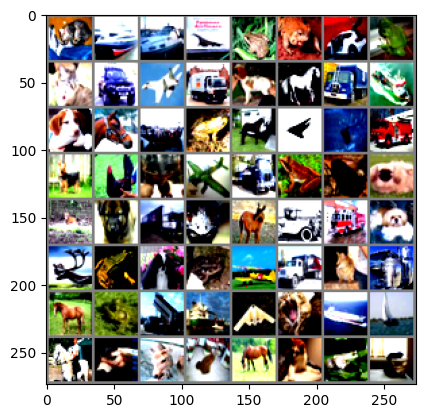

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)
# print images
imshow(torchvision.utils.make_grid(images[0:64]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(64)))

In [ ]:
with torch.no_grad():
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)

In [ ]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


In [ ]:
class_correct,class_total = get_accuracy_per_class(model, testloader, device)
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 71 %
Accuracy of   car : 100 %
Accuracy of  bird : 85 %
Accuracy of   cat : 83 %
Accuracy of  deer : 100 %
Accuracy of   dog : 66 %
Accuracy of  frog : 81 %
Accuracy of horse : 83 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %


## Performance metrics

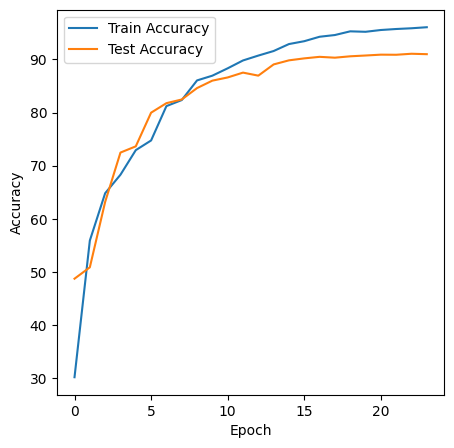

In [ ]:
plot_accuracy(train_acc, test_acc)

## Misclassified Images

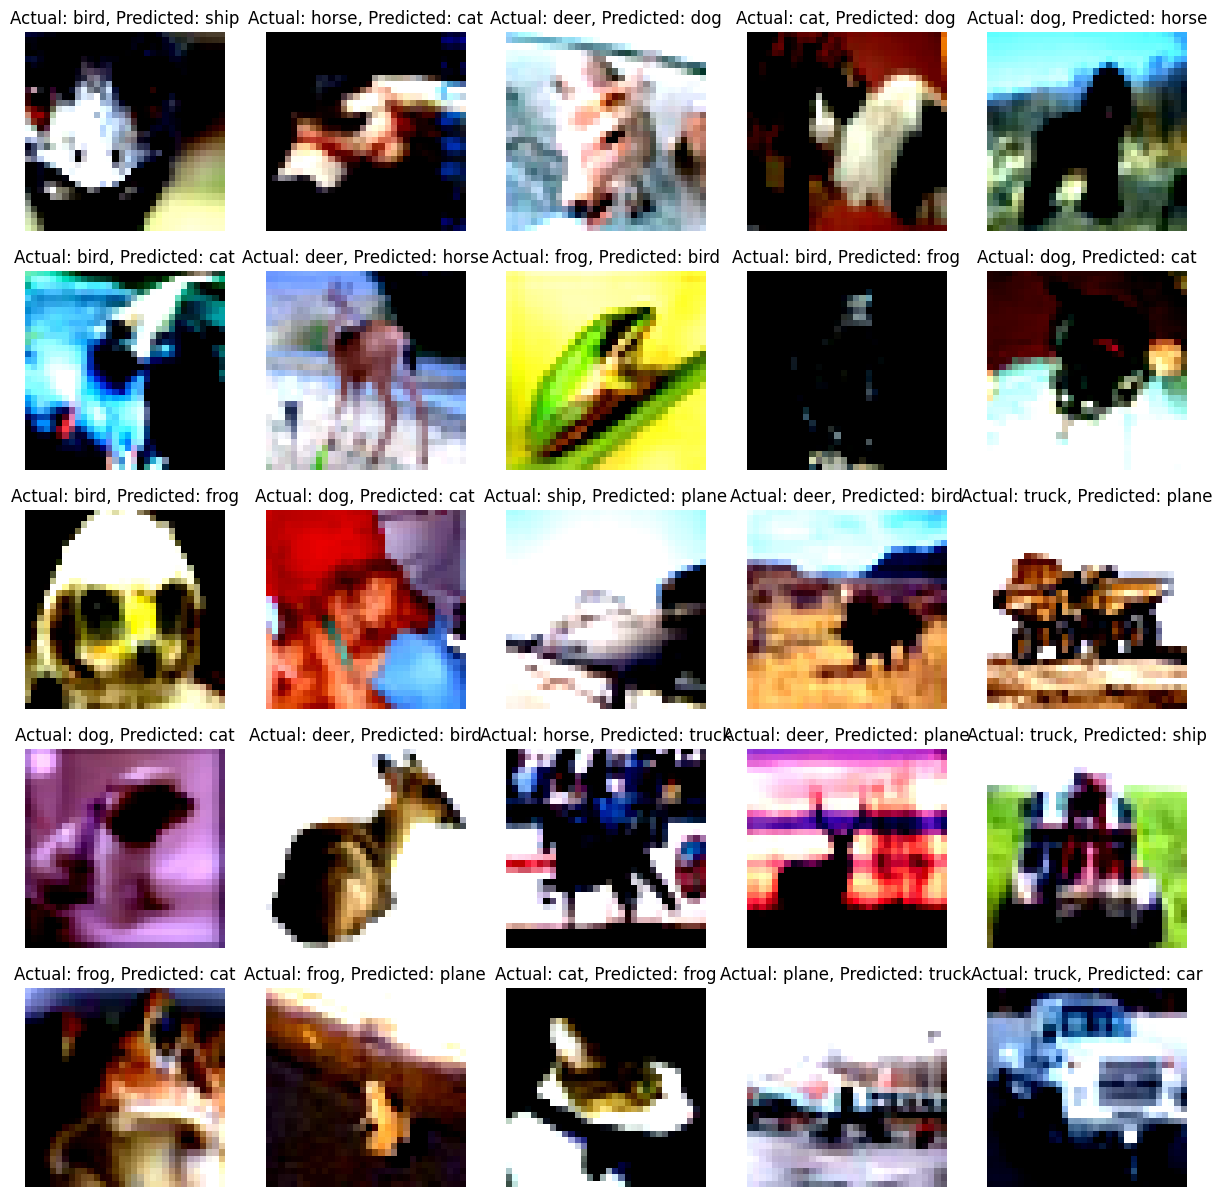

In [ ]:
incorrect_images_list,predicted_label_list,correct_label_list=display_misclassfied_ciphar10_images(testloader, model, device, classes, 25)
